## Import libraries

In [1]:
# !pip install tensorly

import tensorly as tl
from tensorly.decomposition import parafac
from tensorly.decomposition import tucker
from tensorly.decomposition import tensor_train
from math import ceil
from tensorly import tt_to_tensor
from tensorly.decomposition import matrix_product_state
import torch.nn.init as init

In [2]:
"""
5 runs of 50 epochs, seed = 10, 20, 30, 40, 50;
validation accuracies: 0.9492, 0.9457, 0.9463, 0.9439, 0.9455
"""
#from __future__ import print_function, division
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms, utils
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import time
import os
import copy
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import balanced_accuracy_score

print("PyTorch Version:", torch.__version__)
print("Torchvision Version:", torchvision.__version__)
print("GPU is available?", torch.cuda.is_available())

dtype = torch.float64
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

PyTorch Version: 1.13.1
Torchvision Version: 0.14.1
GPU is available? True


## train data processing

In [3]:
df_train_1 = pd.read_csv('/home/c/cl237/Datasets/Flare_LSTM_dataset/M/normalized_training.csv')
df_train_2 = pd.read_csv('/home/c/cl237/Datasets/Flare_LSTM_dataset/M/normalized_validation.csv')
# concat train and validation into train. we don't need validation set
df_train = df_train_1.append(df_train_2).reset_index(drop=True)

# undersampling for "negative" samples
negative_df = df_train[df_train['label'] == 'Negative']
positive_df = df_train[df_train['label'] == 'Positive']

# Get number of "positive" samples
num_positive = len(positive_df)

# take the same number of "negative" samples as there are "positive" samples
balanced_negative_df = negative_df.sample(n=num_positive, random_state=10086)

df_train_balanced = pd.concat([positive_df, balanced_negative_df])
print(df_train_balanced['label'].value_counts())

Positive    4057
Negative    4057
Name: label, dtype: int64


In [4]:
pd_X_train = df_train_balanced.iloc[:, 5:]
pd_y_train = df_train_balanced.iloc[:, 0]

N = len(pd_X_train)
K = 2

pd_X_train = pd_X_train.values
X_train = torch.tensor(pd_X_train, dtype=dtype, device=device)
X_train = torch.t(X_train)

# scaler = MinMaxScaler()
# x = pd_X_train.values
# x_scaled = scaler.fit_transform(x)
# X_train = torch.tensor(x_scaled, dtype=dtype, device=device)
# X_train = torch.t(X_train)

# Initialize the LabelEncoder
encoder = LabelEncoder()
# Fit and transform the y values
y = encoder.fit_transform(pd_y_train.values)
y_train=torch.tensor(y, dtype=torch.long, device=device)
y_train = torch.flatten(y_train)

y_one_hot = torch.zeros(N, K, device=device).scatter_(1, y_train.unsqueeze(1), 1)
y_one_hot = torch.t(y_one_hot).to(device=device)

print(list(encoder.classes_))

['Negative', 'Positive']


## test data processing

In [5]:
df_test = pd.read_csv('/home/c/cl237/Datasets/Flare_LSTM_dataset/M/normalized_testing.csv')

# Undersampling for "negative" samples
#negative_df = df_test[df_test['label'] == 'Negative']
#positive_df = df_test[df_test['label'] == 'Positive']

# Get number of "positive" samples
#num_positive = len(positive_df)

# Take the same number of "negative" samples as there are "positive" samples
#balanced_negative_df = negative_df.sample(n=num_positive, random_state=10086)

#df_test_balanced = pd.concat([positive_df, balanced_negative_df])
#print(df_test_balanced['label'].value_counts())

In [6]:
pd_X_test = df_test.iloc[:, 5:]
pd_y_test = df_test.iloc[:, 0]

N_test = len(pd_X_test)
K = 2

pd_X_test = pd_X_test.values
X_test = torch.tensor(pd_X_test, dtype=dtype, device=device)
X_test = torch.t(X_test)
# x = pd_X_test.values
# x_scaled = scaler.transform(x)  # only transform x, don't fit the scaler again
# X_test = torch.tensor(x_scaled, dtype=dtype, device=device)
# X_test = torch.t(X_test)


# Initialize the LabelEncoder
encoder = LabelEncoder()
# Fit and transform the y values
y = encoder.fit_transform(pd_y_test.values)
y_test=torch.tensor(y, dtype=torch.long, device=device)
y_test = torch.flatten(y_test)

y_test_one_hot = torch.zeros(N_test, K, device=device).scatter_(1, y_test.unsqueeze(1), 1)
y_test_one_hot = torch.t(y_test_one_hot).to(device=device)

In [7]:
print(df_test['label'].value_counts())

Negative    43411
Positive     1278
Name: label, dtype: int64


## Main algorithm

### Define functions for updating blocks

In [8]:
# def updateMask(W, sparsity):
#     torch.dist(V1,nn.ReLU()(U1),2),2).cpu().numpy()
#     Mask
#     Wsparse
#     return Mask, Wsparse

# Wsquare = torch.square(W3)
# Threshold = torch.quantile(torch.reshape(Wsquare, (-1,)), 0.5, interpolation='linear')
# Wsparse = W3
# Wsparse[Wsquare < Threshold] =  0

# Wsparse

In [9]:
def updateV(U1,U2,W,b,rho,gamma):
    _, d = W.size()
    I = torch.eye(d, device=device)
    U1 = nn.ReLU()(U1)
    _, col_U2 = U2.size()
    Vstar = torch.mm(torch.inverse(rho*(torch.mm(torch.t(W),W))+gamma*I), rho*torch.mm(torch.t(W),U2-b.repeat(1,col_U2))+gamma*U1)
    return Vstar

In [10]:
def updateWb_org(U, V, W, b, alpha, rho):
    d,N = V.size()
    I = torch.eye(d, device=device)
    _, col_U = U.size()
    Wstar = torch.mm(alpha*W+rho*torch.mm(U-b.repeat(1,col_U),torch.t(V)),torch.inverse(alpha*I+rho*(torch.mm(V,torch.t(V)))))
    bstar = 0*(alpha*b+rho*torch.sum(U-torch.mm(Wstar,V), dim=1).reshape(b.size()))/(rho*N+alpha)
    return Wstar, bstar

In [11]:
def updateWb(U, V, W, b, W_tensor_rec, alpha, rho,tau):
    W_tensor_rec = torch.as_tensor(W_tensor_rec,device=device).float()
    W_tensor2matrix = W_tensor_rec.reshape(W.shape)
    d,N = V.size()
    I = torch.eye(d, device=device)
    _, col_U = U.size()
    Wstar = torch.mm(alpha*W+tau*W_tensor2matrix+rho*torch.mm(U-b.repeat(1,col_U),torch.t(V)),torch.inverse((alpha+tau)*I+rho*(torch.mm(V,torch.t(V)))))
    bstar = 0*(alpha*b+rho*torch.sum(U-torch.mm(Wstar,V), dim=1).reshape(b.size()))/(rho*N+alpha)
    return Wstar, bstar

In [12]:
def updateWbsparse(U, V, W, b,  W_tensor2matrix, alpha, rho,tau):
    d,N = V.size()
    I = torch.eye(d, device=device)
    _, col_U = U.size()
    Wstar = torch.mm(alpha*W+tau*W_tensor2matrix+rho*torch.mm(U-b.repeat(1,col_U),torch.t(V)),torch.inverse((alpha+tau)*I+rho*(torch.mm(V,torch.t(V)))))
    bstar = 0*(alpha*b+rho*torch.sum(U-torch.mm(Wstar,V), dim=1).reshape(b.size()))/(rho*N+alpha)
    return Wstar, bstar

### Define the proximal operator of the ReLU activation function

In [13]:
def relu_prox(a, b, gamma, d, N):
    val = torch.empty(d,N, device=device)
    x = (a+gamma*b)/(1+gamma)
    y = torch.min(b,torch.zeros(d,N, device=device))

    val = torch.where(a+gamma*b < 0, y, torch.zeros(d,N, device=device))
    val = torch.where(((a+gamma*b >= 0) & (b >=0)) | ((a*(gamma-np.sqrt(gamma*(gamma+1))) <= gamma*b) & (b < 0)), x, val)
    val = torch.where((-a <= gamma*b) & (gamma*b <= a*(gamma-np.sqrt(gamma*(gamma+1)))), b, val)
    return val

### Effective Sparsity

In [14]:
def process_weights(W1, W2, W3):
    # Clone the tensors to keep the originals unchanged
    W1, W2, W3 = W1.clone(), W2.clone(), W3.clone()

    while True:
        # Store a copy of the current weights
        old_W1, old_W2, old_W3 = W1.clone(), W2.clone(), W3.clone()

        # Check all rows of W1
        # If all values in a row of W1 are 0, set corresponding column in W2 to 0
        zero_rows_W1 = torch.all(W1 == 0, dim=1)
        W2[:, zero_rows_W1] = 0

        # Check all columns of W2
        # If all values in a column of W2 are 0, set corresponding row in W1 to 0
        zero_cols_W2 = torch.all(W2 == 0, dim=0)
        W1[zero_cols_W2, :] = 0

        # Check all rows of W2
        # If all values in a row of W2 are 0, set corresponding column in W3 to 0
        zero_rows_W2 = torch.all(W2 == 0, dim=1)
        W3[:, zero_rows_W2] = 0

        # Check if matrices are unchanged
        if torch.equal(W1, old_W1) and torch.equal(W2, old_W2) and torch.equal(W3, old_W3):
            break

    return W1, W2, W3

### Parameter initialization

In [15]:
#df = pd.DataFrame()
#df.to_csv('/home/c/cl237/TenBCD/Sparse/LeNet300_100/Flare(BCD method)/differernt gamma rho/result.csv')

niter = 1000
sparsity = 0.9

tau = 200
alpha = 1
rho = 1
gamma = 100

        

# Do something with these parameters
print(sparsity, tau, gamma, rho, alpha)

loss1 = np.empty(niter)
loss2 = np.empty(niter)
accuracy_train = np.empty(niter)
accuracy_test = np.empty(niter)
time1 = np.empty(niter)
bacc_train = np.empty(niter)
bacc_test = np.empty(niter)
true_sparsity = np.empty(niter)
effective_sparsity = np.empty(niter)

results = torch.zeros(1, 9, niter)

for Out_iter in range(1):
    rank_initial = 700
    seed = 10 + 10*Out_iter
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.manual_seed(seed)

    d0 = 40
    d1 =  300
    d2 =  100
    d3 = K # Layers: input + 2 hidden + output

    std_W1 = torch.sqrt(torch.tensor(1. / d0))
    W1 =0.25* torch.empty(d1, d0, device=device, dtype=dtype).normal_(0, std_W1)
    b1 = 0*torch.ones(d1, 1, dtype=torch.float64,device=device)
    W1square = torch.square(W1)
    Threshold = torch.quantile(torch.reshape(W1square, (-1,)), sparsity, interpolation='linear')
    W1sparse = W1
    W1sparse[W1square < Threshold] =  0

    std_W2 = torch.sqrt(torch.tensor(1. / d1))
    W2 =0.25* torch.empty(d2, d1, device=device, dtype=dtype).normal_(0, std_W2)
    b2 = 0*torch.ones(d2, 1, dtype=torch.float64,device=device)
    W2square = torch.square(W2)
    Threshold = torch.quantile(torch.reshape(W2square, (-1,)), sparsity, interpolation='linear')
    W2sparse = W2
    W2sparse[W2square < Threshold] =  0


    std_W3 = torch.sqrt(torch.tensor(1. / d2))
    W3 =0.25* torch.empty(d3, d2, device=device, dtype=dtype).normal_(0, std_W3)
    b3 = 0*torch.ones(d3, 1, dtype=torch.float64,device=device)
    # W3square = torch.square(W3)
    # Threshold = torch.quantile(torch.reshape(W3square, (-1,)), sparsity, interpolation='linear')
    # W3sparse = W3
    # W3sparse[W3square < Threshold] =  0


    U1 = torch.addmm(b1.repeat(1, N), W1, X_train)
    V1 = nn.ReLU()(U1)
    U2 = torch.addmm(b2.repeat(1, N), W2, V1)
    V2 = nn.ReLU()(U2)
    U3 = torch.addmm(b3.repeat(1, N), W3, V2)
    V3 = U3
    # U4 = torch.addmm(b4.repeat(1, N), W4, V3)
    # V4 = U4


    print('Train on', N, 'samples, validate on', N_test, 'samples')

    for k in range(niter):

        start = time.time()

        # update V4
        V3 = (y_one_hot + gamma*U3 + alpha*V3)/(1 + gamma + alpha)

        # update U4
        U3 = (gamma*V3 + rho*(torch.mm(W3,V2) + b3.repeat(1,N)))/(gamma + rho)

        # update W4 and b4
        W3, b3 = updateWb_org(U3,V2,W3,b3, alpha,rho)
        # W3square = torch.square(W3)
        # Threshold = torch.quantile(torch.reshape(W3square, (-1,)), sparsity, interpolation='linear')
        # W3sparse = W3
        # W3sparse[W3square < Threshold] =  0
        # update V2
        V2 = updateV(U2,U3,W3,b3,rho,gamma)

        # update U2
        U2 = relu_prox(V2,(rho*torch.addmm(b2.repeat(1,N), W2, V1) + alpha*U2)/(rho + alpha),(rho + alpha)/gamma,d2,N)

        # update W2 and b2

        W2, b2 = updateWbsparse(U2,V1,W2,b2,W2sparse, alpha,rho,tau)
        W2square = torch.square(W2)
        Threshold = torch.quantile(torch.reshape(W2square, (-1,)), sparsity, interpolation='linear')
        W2sparse = W2
        W2sparse[W2square < Threshold] =  0

        # update V1
        V1 = updateV(U1,U2,W2,b2,rho,gamma)

        # update U1
        U1 = relu_prox(V1,(rho*torch.addmm(b1.repeat(1,N), W1, X_train) + alpha*U1)/(rho + alpha),(rho + alpha)/gamma,d1,N)

        # update W1 and b1
        W1, b1 = updateWbsparse(U1,X_train,W1,b1,W1sparse, alpha,rho,tau)
        W1square = torch.square(W1)
        Threshold = torch.quantile(torch.reshape(W1square, (-1,)), sparsity, interpolation='linear')
        W1sparse = W1
        W1sparse[W1square < Threshold] =  0

        a1_train = nn.ReLU()(torch.addmm(b1.repeat(1, N), W1sparse, X_train)).double()
        a2_train = nn.ReLU()(torch.addmm(b2.repeat(1, N),  W2sparse, a1_train)).double()
        pred = torch.argmax(torch.addmm(b3.repeat(1, N), W3, a2_train), dim=0)

        a1_test = nn.ReLU()(torch.addmm(b1.repeat(1, N_test), W1sparse, X_test)).double()
        a2_test = nn.ReLU()(torch.addmm(b2.repeat(1, N_test),  W2sparse, a1_test)).double()
        pred_test = torch.argmax(torch.addmm(b3.repeat(1, N_test), W3, a2_test), dim=0)


        loss1[k] = gamma/2*torch.pow(torch.dist(V3,y_one_hot,2),2).cpu().numpy()
        loss2[k] = loss1[k] + rho/2*torch.pow(torch.dist(torch.addmm(b1.repeat(1,N), W1sparse, X_train),U1,2),2).cpu().numpy() \
        +rho/2*torch.pow(torch.dist(torch.addmm(b2.repeat(1,N),  W2sparse, V1),U2,2),2).cpu().numpy() \
        +rho/2*torch.pow(torch.dist(torch.addmm(b3.repeat(1,N), W3, V2),U3,2),2).cpu().numpy() \
        + gamma/2*torch.pow(torch.dist(V1,nn.ReLU()(U1),2),2).cpu().numpy() \
        + gamma/2*torch.pow(torch.dist(V2,nn.ReLU()(U2),2),2).cpu().numpy() \
        + gamma/2*torch.pow(torch.dist(V3,U3,2),2).cpu().numpy() \
        + tau/2*torch.pow(torch.dist(W1,W1sparse,2),2).cpu().numpy()\
        + tau/2*torch.pow(torch.dist(W2,W2sparse,2),2).cpu().numpy()\
        # + tau/2*torch.pow(torch.dist(W3,W3sparse,2),2).cpu().numpy()

        # compute training accuracy
        correct_train = pred == y_train
        accuracy_train[k] = np.mean(correct_train.cpu().numpy())

        # compute validation accuracy
        correct_test = pred_test == y_test
        accuracy_test[k] = np.mean(correct_test.cpu().numpy())


        pred_train_np = pred.cpu().numpy()
        y_train_np = y_train.cpu().numpy()
        pred_test_np = pred_test.cpu().numpy()
        y_test_np = y_test.cpu().numpy()

        bacc_train[k] = balanced_accuracy_score(y_train_np, pred_train_np)
        bacc_test[k] = balanced_accuracy_score(y_test_np, pred_test_np)

        # compute training time
        stop = time.time()
        duration = stop - start
        time1[k] = duration

        # sparsity
        num_zeros_W1 = torch.sum(W1 == 0).item()
        num_zeros_W2 = torch.sum(W2 == 0).item()
        num_zeros_W3 = torch.sum(W3 == 0).item()
        total_zeros_old = num_zeros_W1 + num_zeros_W2 + num_zeros_W3
        total_weights = d0*d1+d1*d2+d2*d3
        true_sparsity[k] = total_zeros_old / total_weights

        new_W1, new_W2, new_W3 = process_weights(W1, W2, W3)
        num_zeros_W1_new = torch.sum(new_W1 == 0).item()
        num_zeros_W2_new = torch.sum(new_W2 == 0).item()
        num_zeros_W3_new = torch.sum(new_W3 == 0).item()
        total_zeros = num_zeros_W1_new + num_zeros_W2_new + num_zeros_W3_new
        total_weights = d0*d1+d1*d2+d2*d3
        effective_sparsity[k] = total_zeros / total_weights


        # print results
        print('Epoch', k + 1, '/', niter, '\n',
              '-', 'time:', time1[k], '-', 'sq_loss:', loss1[k], '-', 'tot_loss:', loss2[k],
              '-', 'acc:', accuracy_train[k], '-', 'val_acc:', accuracy_test[k],
              '-', 'bacc_train:', bacc_train[k], '-', 'bacc_test:', bacc_test[k],'-', 'true_sparsity:', true_sparsity[k],
             '-', 'effective_sparsity:', effective_sparsity[k])


    results[Out_iter,0,:] = torch.tensor(loss1)
    results[Out_iter,1,:] = torch.tensor(loss2)
    results[Out_iter,2,:] = torch.tensor(accuracy_train)
    results[Out_iter,3,:] = torch.tensor(accuracy_test)
    results[Out_iter,4,:] = torch.tensor(time1)
    results[Out_iter,5,:] = torch.tensor(bacc_train)
    results[Out_iter,6,:] = torch.tensor(bacc_test)
    results[Out_iter,7,:] = torch.tensor(true_sparsity)
    results[Out_iter,8,:] = torch.tensor(effective_sparsity)

#             df=pd.read_csv('/home/c/cl237/TenBCD/Sparse/LeNet300_100/Flare(BCD method)/differernt gamma rho/result.csv')
#             new_row = {
#                         'tau': tau, 
#                         'gamma': gamma, 
#                         'rho': rho, 
#                         'alpha': alpha,
#                         'loss1': loss1[niter-1], 
#                         'loss2': loss2[niter-1], 
#                         'accuracy_train': accuracy_train[niter-1],
#                         'accuracy_test': accuracy_test[niter-1], 
#                         'max_accuracy_train': max(accuracy_train),
#                         'max_accuracy_test': max(accuracy_test),
#                         'time': time1[niter-1], 
#                         'BACC_train': bacc_train[niter-1],
#                         'BACC_test': bacc_test[niter-1],
#                         'max_BACC_train': max(bacc_train),
#                         'max_BACC_test': max(bacc_test),
#                         'Sparsity': sparsity,
#                         'seed' : seed
#                     }

#             df=df.append(new_row,ignore_index=True)
#             df.to_csv('/home/c/cl237/TenBCD/Sparse/LeNet300_100/Flare(BCD method)/differernt gamma rho/result.csv',index=False)

filename="LecunNormal_" + "niter_"+ str(niter) + "Sparsity_" + str(sparsity) +"tau_" + str(tau) + "gamma_" + str(gamma) + \
                "rho_" + str(rho) + "alpha_" + str(alpha)+ ".mat"
from scipy.io import savemat
%cd /home/c/cl237/TenBCD/Sparse/LeNet300_100/Flare(BCD method)/different init/
savemat (filename, {'results': torch.Tensor.numpy(results)})

0.9 200 100 1 1
Train on 8114 samples, validate on 44689 samples
Epoch 1 / 1000 
 - time: 0.23884797096252441 - sq_loss: 398348.18430561904 - tot_loss: 398348.3033105758 - acc: 0.6056199161942322 - val_acc: 0.9033542930027524 - bacc_train: 0.6056199161942322 - bacc_test: 0.6164819922429388 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 2 / 1000 
 - time: 0.02806544303894043 - sq_loss: 390651.5450468908 - tot_loss: 390651.9757989239 - acc: 0.77384767069263 - val_acc: 0.8904428382823514 - bacc_train: 0.77384767069263 - bacc_test: 0.7784312201868309 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 3 / 1000 
 - time: 0.028301715850830078 - sq_loss: 383130.874249507 - tot_loss: 383131.78172928107 - acc: 0.8275819571111659 - val_acc: 0.8845577211394303 - bacc_train: 0.8275819571111659 - bacc_test: 0.8691925007360408 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 4 / 1000 
 - time: 0.0282

Epoch 32 / 1000 
 - time: 0.02683258056640625 - sq_loss: 218588.52080300322 - tot_loss: 218589.150897492 - acc: 0.8534631501109194 - val_acc: 0.8816711047461344 - bacc_train: 0.8534631501109193 - bacc_test: 0.8851737526842914 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 33 / 1000 
 - time: 0.026842832565307617 - sq_loss: 214373.54694628392 - tot_loss: 214374.1815409685 - acc: 0.8532166625585408 - val_acc: 0.8819620040725906 - bacc_train: 0.8532166625585408 - bacc_test: 0.8857032028077954 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 34 / 1000 
 - time: 0.02680039405822754 - sq_loss: 210239.6151433571 - tot_loss: 210240.25481237902 - acc: 0.8532166625585408 - val_acc: 0.8820291346863881 - bacc_train: 0.8532166625585408 - bacc_test: 0.8861174747506537 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 35 / 1000 
 - time: 0.026892662048339844 - sq_loss: 206185.19401871003 - tot_loss:

Epoch 64 / 1000 
 - time: 0.026958227157592773 - sq_loss: 117194.12131599817 - tot_loss: 117194.91481443483 - acc: 0.8544491003204339 - val_acc: 0.881894873458793 - bacc_train: 0.8544491003204338 - bacc_test: 0.893263019126896 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 65 / 1000 
 - time: 0.02683711051940918 - sq_loss: 114932.71148692838 - tot_loss: 114933.50869663006 - acc: 0.8544491003204339 - val_acc: 0.881894873458793 - bacc_train: 0.8544491003204338 - bacc_test: 0.893263019126896 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 66 / 1000 
 - time: 0.02675604820251465 - sq_loss: 112714.92256178956 - tot_loss: 112715.72340278536 - acc: 0.8543258565442445 - val_acc: 0.8818053659737296 - bacc_train: 0.8543258565442444 - bacc_test: 0.8932169478546379 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 67 / 1000 
 - time: 0.026829242706298828 - sq_loss: 110539.91418092797 - tot_loss:

Epoch 96 / 1000 
 - time: 0.026800870895385742 - sq_loss: 62820.052834714304 - tot_loss: 62820.93099385227 - acc: 0.8554350505299483 - val_acc: 0.881581597261071 - bacc_train: 0.8554350505299482 - bacc_test: 0.8972786730493043 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 97 / 1000 
 - time: 0.027164459228515625 - sq_loss: 61607.74471033712 - tot_loss: 61608.62466818208 - acc: 0.855311806753759 - val_acc: 0.8816039741323368 - bacc_train: 0.855311806753759 - bacc_test: 0.8972901908673688 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 98 / 1000 
 - time: 0.027057886123657227 - sq_loss: 60418.83215666714 - tot_loss: 60419.71388727946 - acc: 0.8554350505299483 - val_acc: 0.8815368435185392 - bacc_train: 0.8554350505299482 - bacc_test: 0.89763535590184 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 99 / 1000 
 - time: 0.02681899070739746 - sq_loss: 59252.86386414999 - tot_loss: 59253

Epoch 128 / 1000 
 - time: 0.026833057403564453 - sq_loss: 33673.56531561705 - tot_loss: 33674.58687920285 - acc: 0.8556815380823268 - val_acc: 0.8805522611828415 - bacc_train: 0.8556815380823268 - bacc_test: 0.8978880088843293 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 129 / 1000 
 - time: 0.02682018280029297 - sq_loss: 33023.773218562455 - tot_loss: 33024.81602394834 - acc: 0.8559280256347055 - val_acc: 0.8803284924701829 - bacc_train: 0.8559280256347055 - bacc_test: 0.8977728307036839 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 130 / 1000 
 - time: 0.026803970336914062 - sq_loss: 32386.51938572091 - tot_loss: 32387.587479426922 - acc: 0.8556815380823268 - val_acc: 0.8801942312425877 - bacc_train: 0.8556815380823268 - bacc_test: 0.8977037237952966 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 131 / 1000 
 - time: 0.02687859535217285 - sq_loss: 31761.56368648011 - tot_lo

Epoch 160 / 1000 
 - time: 0.02682042121887207 - sq_loss: 18051.290606925166 - tot_loss: 18072.295874482483 - acc: 0.8580231698299235 - val_acc: 0.8791201414218264 - bacc_train: 0.8580231698299235 - bacc_test: 0.9009480534148456 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 161 / 1000 
 - time: 0.026816844940185547 - sq_loss: 17703.0101259388 - tot_loss: 17726.834580134233 - acc: 0.8580231698299235 - val_acc: 0.8791201414218264 - bacc_train: 0.8580231698299235 - bacc_test: 0.9009480534148456 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 162 / 1000 
 - time: 0.027108430862426758 - sq_loss: 17361.451702464205 - tot_loss: 17388.572893435223 - acc: 0.8580231698299235 - val_acc: 0.8790753876792947 - bacc_train: 0.8580231698299235 - bacc_test: 0.9009250177787165 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 163 / 1000 
 - time: 0.02680063247680664 - sq_loss: 17026.485410206617 - tot

Epoch 192 / 1000 
 - time: 0.02692699432373047 - sq_loss: 9677.943092780319 - tot_loss: 9723.200842302389 - acc: 0.8581464136061129 - val_acc: 0.8790977645505605 - bacc_train: 0.8581464136061129 - bacc_test: 0.9013162540854458 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 193 / 1000 
 - time: 0.026906967163085938 - sq_loss: 9491.264607894962 - tot_loss: 9536.290556589223 - acc: 0.8581464136061129 - val_acc: 0.8790753876792947 - bacc_train: 0.8581464136061129 - bacc_test: 0.9013047362673812 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 194 / 1000 
 - time: 0.02683281898498535 - sq_loss: 9308.18873125309 - tot_loss: 9352.851381553925 - acc: 0.8582696573823022 - val_acc: 0.879030633936763 - bacc_train: 0.8582696573823021 - bacc_test: 0.9012817006312521 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 195 / 1000 
 - time: 0.026832103729248047 - sq_loss: 9128.64594057687 - tot_loss: 9

Epoch 224 / 1000 
 - time: 0.026787519454956055 - sq_loss: 5189.6909149277335 - tot_loss: 5208.7366690212375 - acc: 0.8588858762632487 - val_acc: 0.8783593277987872 - bacc_train: 0.8588858762632487 - bacc_test: 0.9009361660893158 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 225 / 1000 
 - time: 0.026867389678955078 - sq_loss: 5089.623969234445 - tot_loss: 5108.149243705074 - acc: 0.8588858762632487 - val_acc: 0.8784264584125847 - bacc_train: 0.8588858762632487 - bacc_test: 0.9009707195435095 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 226 / 1000 
 - time: 0.027139663696289062 - sq_loss: 4991.488230550406 - tot_loss: 5009.559536607015 - acc: 0.859009120039438 - val_acc: 0.8784712121551165 - bacc_train: 0.8590091200394381 - bacc_test: 0.9009937551796385 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 227 / 1000 
 - time: 0.027078866958618164 - sq_loss: 4895.246331302277 - tot_l

Epoch 256 / 1000 
 - time: 0.027029037475585938 - sq_loss: 2783.7487599156516 - tot_loss: 2791.7944279477147 - acc: 0.860241557801331 - val_acc: 0.8784264584125847 - bacc_train: 0.860241557801331 - bacc_test: 0.9009707195435095 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 257 / 1000 
 - time: 0.026831865310668945 - sq_loss: 2730.103685058505 - tot_loss: 2738.262102255499 - acc: 0.860241557801331 - val_acc: 0.8784040815413189 - bacc_train: 0.860241557801331 - bacc_test: 0.9009592017254449 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 258 / 1000 
 - time: 0.0268557071685791 - sq_loss: 2677.49337050316 - tot_loss: 2685.7906020877713 - acc: 0.8601183140251417 - val_acc: 0.8784488352838506 - bacc_train: 0.8601183140251417 - bacc_test: 0.9009822373615739 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 259 / 1000 
 - time: 0.02682971954345703 - sq_loss: 2625.8979067978953 - tot_loss: 

Epoch 288 / 1000 
 - time: 0.026854753494262695 - sq_loss: 1493.7979336853562 - tot_loss: 1503.7530452678363 - acc: 0.8609810204584668 - val_acc: 0.8782474434424579 - bacc_train: 0.8609810204584669 - bacc_test: 0.9001191400216636 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 289 / 1000 
 - time: 0.026830196380615234 - sq_loss: 1465.031678387423 - tot_loss: 1474.4008193020707 - acc: 0.8611042642346561 - val_acc: 0.8781355590861286 - bacc_train: 0.8611042642346561 - bacc_test: 0.9000615509313409 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 290 / 1000 
 - time: 0.02689051628112793 - sq_loss: 1436.8201773666 - tot_loss: 1445.7533753120679 - acc: 0.8612275080108455 - val_acc: 0.8780460516010652 - bacc_train: 0.8612275080108455 - bacc_test: 0.9000154796590827 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 291 / 1000 
 - time: 0.02683424949645996 - sq_loss: 1409.1525913180678 - tot_l

Epoch 320 / 1000 
 - time: 0.026816129684448242 - sq_loss: 802.0354640946834 - tot_loss: 807.3552339432125 - acc: 0.8598718264727632 - val_acc: 0.8807536530242341 - bacc_train: 0.8598718264727632 - bacc_test: 0.9010294171562281 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 321 / 1000 
 - time: 0.027054786682128906 - sq_loss: 786.6070209074452 - tot_loss: 791.902430849415 - acc: 0.8598718264727632 - val_acc: 0.8807984067667659 - bacc_train: 0.8598718264727632 - bacc_test: 0.9018118897696865 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 322 / 1000 
 - time: 0.026892662048339844 - sq_loss: 771.4757737032744 - tot_loss: 776.7518121718942 - acc: 0.8598718264727632 - val_acc: 0.8808207836380317 - bacc_train: 0.8598718264727632 - bacc_test: 0.9018234075877511 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 323 / 1000 
 - time: 0.027034282684326172 - sq_loss: 756.6359874693708 - tot_los

Epoch 352 / 1000 
 - time: 0.02679610252380371 - sq_loss: 430.9330244585109 - tot_loss: 438.7004459653075 - acc: 0.8613507517870348 - val_acc: 0.885094766049811 - bacc_train: 0.8613507517870347 - bacc_test: 0.8990869704854381 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 353 / 1000 
 - time: 0.02680063247680664 - sq_loss: 422.65629364626227 - tot_loss: 430.68663949779443 - acc: 0.8617204831156027 - val_acc: 0.8851171429210768 - bacc_train: 0.8617204831156027 - bacc_test: 0.8990984883035025 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 354 / 1000 
 - time: 0.02678394317626953 - sq_loss: 414.53918084464414 - tot_loss: 422.85424207346955 - acc: 0.8615972393394133 - val_acc: 0.8851395197923426 - bacc_train: 0.8615972393394133 - bacc_test: 0.8987302876329024 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 355 / 1000 
 - time: 0.026845693588256836 - sq_loss: 406.5785477335906 - tot_lo

Epoch 384 / 1000 
 - time: 0.026875972747802734 - sq_loss: 231.82181823401731 - tot_loss: 274.3898987351938 - acc: 0.8623367019965492 - val_acc: 0.8842444449417083 - bacc_train: 0.8623367019965491 - bacc_test: 0.8971304194443264 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 385 / 1000 
 - time: 0.026858806610107422 - sq_loss: 227.37821825907417 - tot_loss: 272.65792456163376 - acc: 0.8620902144441706 - val_acc: 0.8842444449417083 - bacc_train: 0.8620902144441706 - bacc_test: 0.8971304194443264 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 386 / 1000 
 - time: 0.026862144470214844 - sq_loss: 223.02009120649294 - tot_loss: 264.74160380965986 - acc: 0.8623367019965492 - val_acc: 0.8843115755555059 - bacc_train: 0.8623367019965491 - bacc_test: 0.89716497289852 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 387 / 1000 
 - time: 0.02678680419921875 - sq_loss: 218.74580636035157 - tot

Epoch 416 / 1000 
 - time: 0.02707386016845703 - sq_loss: 124.8829056098432 - tot_loss: 266.84199357475563 - acc: 0.8635691397584422 - val_acc: 0.8826780639530981 - bacc_train: 0.8635691397584422 - bacc_test: 0.8944255797364846 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 417 / 1000 
 - time: 0.02688884735107422 - sq_loss: 122.49535862632975 - tot_loss: 269.832965467306 - acc: 0.8636923835346315 - val_acc: 0.8828347020519591 - bacc_train: 0.8636923835346315 - bacc_test: 0.8945062044629364 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 418 / 1000 
 - time: 0.02682971954345703 - sq_loss: 120.15387171542962 - tot_loss: 273.022664289901 - acc: 0.864308602415578 - val_acc: 0.883013717022086 - bacc_train: 0.8643086024155779 - bacc_test: 0.8945983470074528 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 419 / 1000 
 - time: 0.026808500289916992 - sq_loss: 117.85748441689124 - tot_loss:

Epoch 448 / 1000 
 - time: 0.026851892471313477 - sq_loss: 67.41005113066932 - tot_loss: 384.4152428371503 - acc: 0.8638156273108208 - val_acc: 0.8832151088634788 - bacc_train: 0.8638156273108208 - bacc_test: 0.889006230040063 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 449 / 1000 
 - time: 0.026768207550048828 - sq_loss: 66.12596455447913 - tot_loss: 355.24524782826416 - acc: 0.8636923835346315 - val_acc: 0.8834388775761373 - bacc_train: 0.8636923835346315 - bacc_test: 0.8891214082207084 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 450 / 1000 
 - time: 0.026812076568603516 - sq_loss: 64.86655055471255 - tot_loss: 340.70494229261095 - acc: 0.8636923835346315 - val_acc: 0.8835283850612008 - bacc_train: 0.8636923835346315 - bacc_test: 0.8891674794929665 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 451 / 1000 
 - time: 0.026836156845092773 - sq_loss: 63.63133608151107 - tot_l

Epoch 480 / 1000 
 - time: 0.026993751525878906 - sq_loss: 36.4877728287302 - tot_loss: 389.20278191454287 - acc: 0.8639388710870101 - val_acc: 0.8893911253328559 - bacc_train: 0.8639388710870102 - bacc_test: 0.8880082444505657 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 481 / 1000 
 - time: 0.026806354522705078 - sq_loss: 35.79660277039363 - tot_loss: 386.41663778812915 - acc: 0.8635691397584422 - val_acc: 0.8895925171742487 - bacc_train: 0.8635691397584422 - bacc_test: 0.8881119048131465 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 482 / 1000 
 - time: 0.026779890060424805 - sq_loss: 35.11865623685617 - tot_loss: 386.402280292569 - acc: 0.8634458959822529 - val_acc: 0.8900848083420976 - bacc_train: 0.8634458959822529 - bacc_test: 0.8883652968105666 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 483 / 1000 
 - time: 0.026885986328125 - sq_loss: 34.45367606992691 - tot_loss:

Epoch 512 / 1000 
 - time: 0.026820659637451172 - sq_loss: 19.826313460670743 - tot_loss: 513.3702856492786 - acc: 0.8645550899679566 - val_acc: 0.8940455145561548 - bacc_train: 0.8645550899679566 - bacc_test: 0.8881256396760029 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 513 / 1000 
 - time: 0.026885509490966797 - sq_loss: 19.453389980894606 - tot_loss: 435.11688808942534 - acc: 0.8646783337441459 - val_acc: 0.894023137684889 - bacc_train: 0.8646783337441459 - bacc_test: 0.8881141218579383 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 514 / 1000 
 - time: 0.02680802345275879 - sq_loss: 19.08757186002992 - tot_loss: 411.2533158182716 - acc: 0.8649248212965245 - val_acc: 0.894023137684889 - bacc_train: 0.8649248212965245 - bacc_test: 0.8881141218579383 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 515 / 1000 
 - time: 0.027069568634033203 - sq_loss: 18.72872612032485 - tot_lo

Epoch 544 / 1000 
 - time: 0.026867151260375977 - sq_loss: 10.82762662004108 - tot_loss: 294.96591820699877 - acc: 0.8675129405964999 - val_acc: 0.8938664995860279 - bacc_train: 0.8675129405964999 - bacc_test: 0.8884132156201512 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 545 / 1000 
 - time: 0.02680206298828125 - sq_loss: 10.625922832280697 - tot_loss: 299.40223418793994 - acc: 0.8673896968203105 - val_acc: 0.89417977578375 - bacc_train: 0.8673896968203105 - bacc_test: 0.8885744650730549 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 546 / 1000 
 - time: 0.0270388126373291 - sq_loss: 10.428048425942983 - tot_loss: 305.17049751084795 - acc: 0.867143209267932 - val_acc: 0.8944035444964085 - bacc_train: 0.867143209267932 - bacc_test: 0.8886896432537004 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 547 / 1000 
 - time: 0.02682971954345703 - sq_loss: 10.233931733541299 - tot_loss

Epoch 576 / 1000 
 - time: 0.026853322982788086 - sq_loss: 5.955071778622974 - tot_loss: 153.17323853473007 - acc: 0.867143209267932 - val_acc: 0.894336413882611 - bacc_train: 0.8671432092679319 - bacc_test: 0.8871362158448478 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 577 / 1000 
 - time: 0.026812076568603516 - sq_loss: 5.845682042784821 - tot_loss: 145.25142046411838 - acc: 0.867143209267932 - val_acc: 0.894023137684889 - bacc_train: 0.867143209267932 - bacc_test: 0.8865952479032795 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 578 / 1000 
 - time: 0.026807308197021484 - sq_loss: 5.738358160960349 - tot_loss: 150.43077221656802 - acc: 0.8668967217155533 - val_acc: 0.8944706751102061 - bacc_train: 0.8668967217155534 - bacc_test: 0.8864458857759057 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 579 / 1000 
 - time: 0.02683877944946289 - sq_loss: 5.6330578467037045 - tot_loss

Epoch 608 / 1000 
 - time: 0.026888608932495117 - sq_loss: 3.3077179189385264 - tot_loss: 93.94341926894361 - acc: 0.8672664530441213 - val_acc: 0.8919868423996957 - bacc_train: 0.8672664530441212 - bacc_test: 0.8866862819253999 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 609 / 1000 
 - time: 0.026843786239624023 - sq_loss: 3.248130227781034 - tot_loss: 92.43666604390619 - acc: 0.8672664530441213 - val_acc: 0.8919868423996957 - bacc_train: 0.8672664530441212 - bacc_test: 0.8866862819253999 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 610 / 1000 
 - time: 0.02683234214782715 - sq_loss: 3.1896580448037537 - tot_loss: 91.05535710603955 - acc: 0.8672664530441213 - val_acc: 0.8920539730134932 - bacc_train: 0.8672664530441212 - bacc_test: 0.8867208353795936 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 611 / 1000 
 - time: 0.02683854103088379 - sq_loss: 3.132279885745769 - tot_lo

Epoch 640 / 1000 
 - time: 0.026961565017700195 - sq_loss: 1.8629342751962854 - tot_loss: 59.23228873501536 - acc: 0.8677594281488785 - val_acc: 0.8948734587929915 - bacc_train: 0.8677594281488785 - bacc_test: 0.8858937695237381 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 641 / 1000 
 - time: 0.026820898056030273 - sq_loss: 1.830341881666041 - tot_loss: 58.10663352091731 - acc: 0.8678826719250677 - val_acc: 0.8948734587929915 - bacc_train: 0.8678826719250677 - bacc_test: 0.8858937695237381 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 642 / 1000 
 - time: 0.026991844177246094 - sq_loss: 1.7983548329217558 - tot_loss: 56.97326599791793 - acc: 0.8677594281488785 - val_acc: 0.8948287050504599 - bacc_train: 0.8677594281488785 - bacc_test: 0.885870733887609 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 643 / 1000 
 - time: 0.026822805404663086 - sq_loss: 1.7669616829554453 - tot_

Epoch 672 / 1000 
 - time: 0.0268709659576416 - sq_loss: 1.0699460457468692 - tot_loss: 31.93889592990897 - acc: 0.8687453783583929 - val_acc: 0.8929042941215959 - bacc_train: 0.8687453783583929 - bacc_test: 0.8845004830453933 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 673 / 1000 
 - time: 0.02688121795654297 - sq_loss: 1.0519648934569614 - tot_loss: 31.56826970153981 - acc: 0.8687453783583929 - val_acc: 0.8928819172503301 - bacc_train: 0.8687453783583929 - bacc_test: 0.884109246738664 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 674 / 1000 
 - time: 0.026778221130371094 - sq_loss: 1.0343120387909712 - tot_loss: 31.19974825199703 - acc: 0.8688686221345822 - val_acc: 0.8928371635077983 - bacc_train: 0.8688686221345822 - bacc_test: 0.8840862111025349 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 675 / 1000 
 - time: 0.026833295822143555 - sq_loss: 1.0169818349676962 - tot_lo

Epoch 704 / 1000 
 - time: 0.02687692642211914 - sq_loss: 0.6311680100983432 - tot_loss: 22.462084132316296 - acc: 0.8693615972393394 - val_acc: 0.8939336301998254 - bacc_train: 0.8693615972393394 - bacc_test: 0.8823722732557093 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 705 / 1000 
 - time: 0.02684617042541504 - sq_loss: 0.6211781338194436 - tot_loss: 22.254822969810977 - acc: 0.8693615972393394 - val_acc: 0.8939336301998254 - bacc_train: 0.8693615972393394 - bacc_test: 0.8823722732557093 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 706 / 1000 
 - time: 0.026831626892089844 - sq_loss: 0.6113675920608642 - tot_loss: 22.050452880719583 - acc: 0.8693615972393394 - val_acc: 0.8939336301998254 - bacc_train: 0.8693615972393394 - bacc_test: 0.8823722732557093 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 707 / 1000 
 - time: 0.02679896354675293 - sq_loss: 0.6017333993731423 - to

Epoch 736 / 1000 
 - time: 0.026769161224365234 - sq_loss: 0.3859542941181519 - tot_loss: 28.032764696659626 - acc: 0.8694848410155287 - val_acc: 0.8945378057240037 - bacc_train: 0.8694848410155287 - bacc_test: 0.8819238173661227 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 737 / 1000 
 - time: 0.026942729949951172 - sq_loss: 0.3803216323982516 - tot_loss: 21.97867988009111 - acc: 0.869608084791718 - val_acc: 0.8945154288527378 - bacc_train: 0.869608084791718 - bacc_test: 0.8815325810593935 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 738 / 1000 
 - time: 0.026941776275634766 - sq_loss: 0.3747875046061472 - tot_loss: 20.419581377823867 - acc: 0.8697313285679074 - val_acc: 0.8945601825952695 - bacc_train: 0.8697313285679074 - bacc_test: 0.8815556166955225 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 739 / 1000 
 - time: 0.026825666427612305 - sq_loss: 0.36935046108491715 - t

Epoch 768 / 1000 
 - time: 0.026859760284423828 - sq_loss: 0.24686236193734004 - tot_loss: 13.021637089459679 - acc: 0.8707172787774218 - val_acc: 0.8946273132090671 - bacc_train: 0.8707172787774218 - bacc_test: 0.8804510146837219 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 769 / 1000 
 - time: 0.02698493003845215 - sq_loss: 0.24364343103220987 - tot_loss: 12.876753339193819 - acc: 0.870840522553611 - val_acc: 0.8945825594665354 - bacc_train: 0.8708405225536111 - bacc_test: 0.8804279790475928 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 770 / 1000 
 - time: 0.026975393295288086 - sq_loss: 0.24047895303165773 - tot_loss: 12.732919074279764 - acc: 0.8707172787774218 - val_acc: 0.8946049363378012 - bacc_train: 0.8707172787774218 - bacc_test: 0.8804394968656575 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 771 / 1000 
 - time: 0.026804447174072266 - sq_loss: 0.23736826015698678

Epoch 800 / 1000 
 - time: 0.026782989501953125 - sq_loss: 0.16680331000201823 - tot_loss: 8.956239037477163 - acc: 0.8713334976583682 - val_acc: 0.8957014030298284 - bacc_train: 0.8713334976583682 - bacc_test: 0.8775864035528377 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 801 / 1000 
 - time: 0.02684640884399414 - sq_loss: 0.1649330466502457 - tot_loss: 8.902653718279232 - acc: 0.8710870101059897 - val_acc: 0.8956790261585625 - bacc_train: 0.8710870101059897 - bacc_test: 0.8771951672461085 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 802 / 1000 
 - time: 0.026837587356567383 - sq_loss: 0.16309334732673028 - tot_loss: 8.850968700323758 - acc: 0.8709637663298003 - val_acc: 0.8956342724160308 - bacc_train: 0.8709637663298003 - bacc_test: 0.8764126946326499 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 803 / 1000 
 - time: 0.026804208755493164 - sq_loss: 0.1612838669192732 - t

Epoch 832 / 1000 
 - time: 0.026816129684448242 - sq_loss: 0.11980681067351034 - tot_loss: 8.002030246662219 - acc: 0.8717032289869362 - val_acc: 0.8960594329700822 - bacc_train: 0.8717032289869362 - bacc_test: 0.8735937852665585 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 833 / 1000 
 - time: 0.02684187889099121 - sq_loss: 0.11869254110344024 - tot_loss: 7.998341436465667 - acc: 0.8717032289869362 - val_acc: 0.896081809841348 - bacc_train: 0.8717032289869362 - bacc_test: 0.8736053030846231 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 834 / 1000 
 - time: 0.02679896354675293 - sq_loss: 0.11759570399424923 - tot_loss: 7.994981437284158 - acc: 0.8715799852107469 - val_acc: 0.8961265635838797 - bacc_train: 0.8715799852107469 - bacc_test: 0.8736283387207522 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 835 / 1000 
 - time: 0.026798486709594727 - sq_loss: 0.11651598943586143 - t

Epoch 864 / 1000 
 - time: 0.026887178421020508 - sq_loss: 0.09134919415122437 - tot_loss: 8.327897070551963 - acc: 0.872442691644072 - val_acc: 0.8944259213676744 - bacc_train: 0.872442691644072 - bacc_test: 0.8742718585025055 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 865 / 1000 
 - time: 0.026852130889892578 - sq_loss: 0.0906574855161185 - tot_loss: 8.361097817003671 - acc: 0.872442691644072 - val_acc: 0.8944035444964085 - bacc_train: 0.872442691644072 - bacc_test: 0.874260340684441 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 866 / 1000 
 - time: 0.0268251895904541 - sq_loss: 0.08997591999641791 - tot_loss: 8.396534639955135 - acc: 0.8723194478678826 - val_acc: 0.8943811676251426 - bacc_train: 0.8723194478678826 - bacc_test: 0.8742488228663765 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 867 / 1000 
 - time: 0.02680063247680664 - sq_loss: 0.08930451655831893 - tot_los

Epoch 896 / 1000 
 - time: 0.026819467544555664 - sq_loss: 0.07359961083839187 - tot_loss: 9.225391263989854 - acc: 0.873305398077397 - val_acc: 0.8955223880597015 - bacc_train: 0.873305398077397 - bacc_test: 0.8774942610083214 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 897 / 1000 
 - time: 0.02678680419921875 - sq_loss: 0.0731631616082351 - tot_loss: 9.128998469365742 - acc: 0.873305398077397 - val_acc: 0.8955447649309674 - bacc_train: 0.873305398077397 - bacc_test: 0.8775057788263858 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 898 / 1000 
 - time: 0.026776552200317383 - sq_loss: 0.07273254259731576 - tot_loss: 9.05546423283587 - acc: 0.873305398077397 - val_acc: 0.8954776343171698 - bacc_train: 0.873305398077397 - bacc_test: 0.8770915068835275 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 899 / 1000 
 - time: 0.02681255340576172 - sq_loss: 0.07230768377420219 - tot_loss

Epoch 928 / 1000 
 - time: 0.026831626892089844 - sq_loss: 0.062136881595902645 - tot_loss: 7.35374942193878 - acc: 0.8737983731821543 - val_acc: 0.8935756002595717 - bacc_train: 0.8737983731821544 - bacc_test: 0.8791502402573589 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 929 / 1000 
 - time: 0.026828289031982422 - sq_loss: 0.061847915645593776 - tot_loss: 7.280373959545181 - acc: 0.8737983731821543 - val_acc: 0.8935979771308376 - bacc_train: 0.8737983731821544 - bacc_test: 0.8791617580754234 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 930 / 1000 
 - time: 0.026827573776245117 - sq_loss: 0.061562496273609144 - tot_loss: 7.208452039420235 - acc: 0.8739216169583436 - val_acc: 0.8934637159032424 - bacc_train: 0.8739216169583436 - bacc_test: 0.8790926511670362 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 931 / 1000 
 - time: 0.02681279182434082 - sq_loss: 0.06128059092177565

Epoch 960 / 1000 
 - time: 0.026793479919433594 - sq_loss: 0.05442073140448336 - tot_loss: 6.781101893245172 - acc: 0.8734286418535864 - val_acc: 0.893687484615901 - bacc_train: 0.8734286418535864 - bacc_test: 0.8780686738816874 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 961 / 1000 
 - time: 0.026927709579467773 - sq_loss: 0.054223540048691884 - tot_loss: 6.824102936327181 - acc: 0.8735518856297757 - val_acc: 0.8936651077446351 - bacc_train: 0.8735518856297757 - bacc_test: 0.8776774375749582 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 962 / 1000 
 - time: 0.02686905860900879 - sq_loss: 0.05402851037316611 - tot_loss: 6.87006187155476 - acc: 0.8735518856297757 - val_acc: 0.893687484615901 - bacc_train: 0.8735518856297757 - bacc_test: 0.8776889553930227 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 963 / 1000 
 - time: 0.026795387268066406 - sq_loss: 0.05383567606607546 - t

Epoch 992 / 1000 
 - time: 0.026829004287719727 - sq_loss: 0.04907114830128236 - tot_loss: 9.126105915538172 - acc: 0.873675129405965 - val_acc: 0.8938664995860279 - bacc_train: 0.873675129405965 - bacc_test: 0.8777810979375391 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 993 / 1000 
 - time: 0.02684807777404785 - sq_loss: 0.048931525694233174 - tot_loss: 9.291483443172787 - acc: 0.8737983731821543 - val_acc: 0.894000760813623 - bacc_train: 0.8737983731821543 - bacc_test: 0.8778502048459264 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 994 / 1000 
 - time: 0.0267794132232666 - sq_loss: 0.04879326225193521 - tot_loss: 9.45650079798505 - acc: 0.873675129405965 - val_acc: 0.8940678914274206 - bacc_train: 0.873675129405965 - bacc_test: 0.8775050398114552 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8959478672985782
Epoch 995 / 1000 
 - time: 0.026752710342407227 - sq_loss: 0.048656555884356564 - tot_l

### Visualization of training results

Text(0.5, 1.0, 'accuracy')

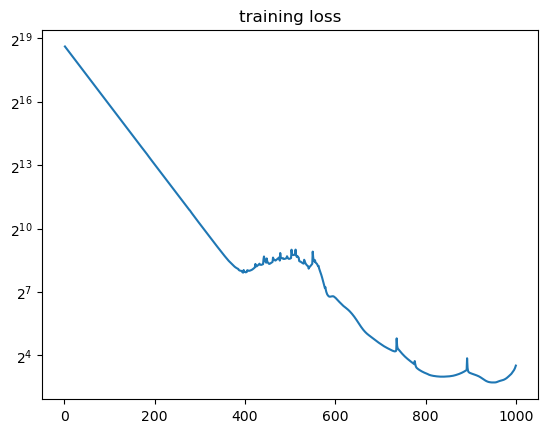

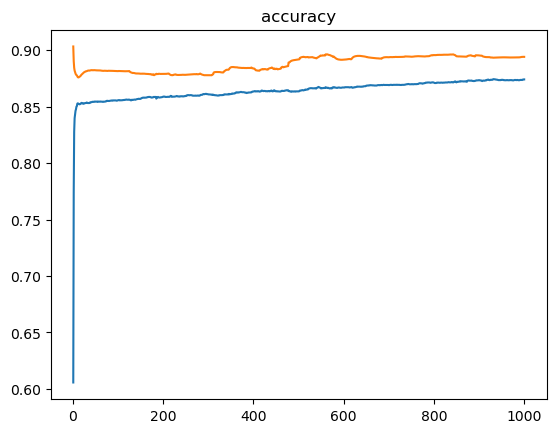

In [16]:
plt.figure()
plt.plot(np.arange(1,niter+1), loss2)
plt.yscale('log',base=2)
plt.title('training loss')

plt.figure()
plt.plot(np.arange(1,niter+1), accuracy_train)
plt.plot(np.arange(1,niter+1), accuracy_test)
plt.title('accuracy')